In [1]:
#necessary imports
from skimage import io
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
import pydicom
import random

In [2]:
dataset = 1
#load the data needed
img_data = io.imread("./data/cta_{}/cardiac_{}.tif".format(dataset,dataset))
tree = ET.parse("./data/cta_{}/cline_RCA.xml".format(dataset))
root = tree.getroot()
#we ignore 4. 5. and 6. dimension and convert the xml data to float
cline_bare = [[float(y) for y in x.text.split()][:3] for x in root.iter() if x.tag == "pos"]

#we will need offset and stuff later this is saved in the dcm file
dcm_data = pydicom.dcmread("./data/cta_{}/cardiac_{}.dcm".format(dataset,dataset))
#this is the x,y distance in mm
pixel_spacing = [float(x) for x in dcm_data.PixelSpacing]
slice_thickness = float(dcm_data.SliceThickness)
slice_spacing = float(dcm_data.SpacingBetweenSlices)
#offset of the first (upper left) voxel
location = [float(x) for x in dcm_data.ImagePositionPatient]

In [3]:
#optionally we can mask the data
mask_data = io.imread("./data/cta_{}/heart_isolationmask.tif".format(dataset))
img_data = np.multiply(img_data,mask_data)

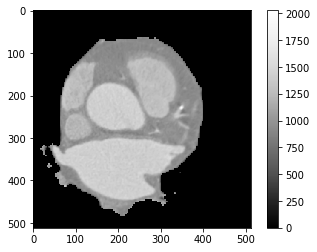

In [4]:
#lets see what we actually got
plt.imshow(img_data[180],cmap="Greys_r");
plt.colorbar()
plt.show()

In [10]:
class Vector3D:
    def __init__(self, x, y, z):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)

    # String representation
    def __str__(self):
        return '<%s, %s, %s>' % (self.x, self.y, self.z)

    # Produce a copy of itself
    def __copy(self):
        return Vector3D(self.x, self.y, self.z)

    # Signing
    def __neg__(self):
        return Vector3D(-self.x, -self.y, -self.z)

    # Scalar Multiplication
    def __mul__(self, number):
        return Vector3D(self.x * number, self.y * number, self.z * number)

    def __rmul__(self, number):
        return self.__mul__(number)

    # Division
    def __truediv__(self, number):
        return self.__copy() * (number**-1)

    # Arithmetic Operations
    def __add__(self, operand):
        return Vector3D(self.x + operand.x, self.y + operand.y, self.z + operand.z)

    def __sub__(self, operand):
        return self.__copy() + -operand

    # Cross product
    # cross = a ** b
    def __pow__(self, operand):
        return Vector3D(self.y*operand.z - self.z*operand.y, 
                            self.z*operand.x - self.x*operand.z, 
                            self.x*operand.y - self.y*operand.x)

    # Dot Project
    # dp = a & b
    def __and__(self, operand):
        return (self.x * operand.x) + \
               (self.y * operand.y) + \
               (self.z * operand.z)
    #SCALE        
    def __or__ (self,operand):
        return Vector3D(self.x * operand.x,self.y * operand.y,self.z*operand.z)
    
    #index [0] 
    def __getitem__(self,key):
        if(key == 0): return self.x
        if(key == 1): return self.y
        if(key == 2): return self.z
        raise Exception("For the indexer, only use 0,1,2 to get the values of x,y and z respectively.")
    # Operations

    def normal(self):
        return self.__copy() / self.magnitude()

    def magnitude(self):
        return (self.x**2 + self.y**2 + self.z**2)**(.5)

ZERO = Vector3D(0,0,0)

In [11]:
#Another Helper Class we will need, that makes things with the images a bit easier and prevents out of bounds access
class SeemlessImage:
    def __init__(self,img):
        self.img = img
        self.x_width = len(img[0])
        self.y_width = len(img)
    
    def get_value(self,x,y):
        if x < 0 or x >= self.x_width or y < 0 or y >= self.y_width:
            return None
        else:
            return self.img[y][x]

In [12]:
#now convert our bare data to vectors to work with
#we need to eliminate the offset

location_v = Vector3D(location[0],location[1],location[2])
cline = [Vector3D(x[0],x[1],x[2]) for x in cline_bare] 

In [13]:
#This class will help us sample the center line in regular distances and directions
class CLine:
    def __init__(self,cline):
        self.cline = cline
        self.directions = list()
        self.lengths = list()
        
        for i in range(len(self.cline)-1):
            delta = self.cline[i+1]-self.cline[i]
            l = delta.magnitude()
            self.lengths.append(l)
            self.directions.append(delta / l) # direction is normalized
        
        #the last length is 0 since there are no more points following
        self.lengths.append(0)
        #the last direction is copied for the last sample of the cline
        self.directions.append(self.directions[len(self.directions) -1])
        
        # calculate the total length of the centerline:
        self.length = sum(self.lengths)
            
    def get_point_and_direction_by_distance(self,distance):
        if distance > self.length or distance < 0:
            raise Exception("Accessed center line out of limits")
        
        index = 0
        
        while(distance > 0):
            distance -= self.lengths[index]
            index += 1
        
        #the last point was the last one before the distance was reached
        #from here we need to go the remaining distance in the direction of the next point
        return (self.cline[index-1] + (distance + self.lengths[index])*self.directions[index-1],self.directions[index-1])

In [14]:
#we just need to give the cline vectorlist to the constructor and the rest will be handled automatically
center_line = CLine(cline)

In [15]:
#this class will handle the interpolation and other stuff with the medical image data
#one mm is one unit within this object
class ContinousImage3D:
    def __init__(self,data,x_scale=1,y_scale=1,z_scale=1,location=Vector3D(0,0,0)):
        self.data = data
        self.shape = [data.shape[2],data.shape[1],data.shape[0]]
        
        #scale is mm/voxel
        self.x_scale = x_scale
        self.y_scale = y_scale
        self.z_scale = z_scale
        
        #sizes in mm
        self.x_size = self.shape[0] * x_scale
        self.y_size = self.shape[1] * y_scale
        self.z_size = self.shape[2] * z_scale
        
        self.size = Vector3D(self.x_size,self.y_size,self.z_size)
        
        #offset of the image in mm (first voxel)
        self.location = location
    
    def is_in(self,vector):
        v = vector - self.location
        
        x = v.x
        y = v.y
        z = v.z
        
        #normalize the x,y,z to voxel distance
        abs_x = x * 1/self.x_scale
        abs_y = y * 1/self.y_scale
        abs_z = z * 1/self.z_scale
        
        #index of the upper left voxel of the needed cube for interpolation
        x_index = int(abs_x)        
        y_index = int(abs_y)        
        z_index = int(abs_z)
        
        #out of bounds
        if x_index < 0 or y_index < 0 or z_index < 0 or \
            x_index >= self.shape[0] - 1 or y_index >= self.shape[1] - 1 or z_index >= self.shape[2] - 1:
            return False
        else:
            return True
        
    def get_value(self,vector):
        #first subtract the offset of the image
        v = vector - self.location
        
        x = v.x
        y = v.y
        z = v.z
        
        #normalize the x,y,z to voxel distance
        abs_x = x * 1/self.x_scale
        abs_y = y * 1/self.y_scale
        abs_z = z * 1/self.z_scale
        
        #index of the upper left voxel of the needed cube for interpolation
        x_index = int(abs_x)
        y_index = int(abs_y)        
        z_index = int(abs_z)
        
        #out of bounds, everything defaults to 0
        if x_index < 0 or y_index < 0 or z_index < 0 \
            or x_index >= self.shape[0] - 1 or y_index >= self.shape[1] - 1 or z_index >= self.shape[2] - 1:
            return 0
        
        #since we transform the data in a unit system, alpha/beta/gamma are equal to the remaining distance in each axis
        alpha = abs_x - x_index
        beta = abs_y - y_index
        gamma = abs_z - z_index
        
        #trilinear interpolation according to slide of M.Tessmann
        f_000 = self.data[z_index][y_index][x_index]
        f_001 = self.data[z_index][y_index][x_index+1]
        f_010 = self.data[z_index][y_index+1][x_index]
        f_011 = self.data[z_index][y_index+1][x_index+1]
        f_100 = self.data[z_index+1][y_index][x_index]
        f_101 = self.data[z_index+1][y_index][x_index+1]
        f_110 = self.data[z_index+1][y_index+1][x_index]
        f_111 = self.data[z_index+1][y_index+1][x_index+1]
        
        f_00 = alpha * f_001 + (1-alpha) * f_000
        f_01 = alpha * f_011 + (1-alpha) * f_010
        f_10 = alpha * f_101 + (1-alpha) * f_100
        f_11 = alpha * f_111 + (1-alpha) * f_110
        
        f_0 = beta * f_01 + (1-beta) * f_00
        f_1 = beta * f_11 + (1-beta) * f_10
        
        return gamma * f_1 + (1-gamma) * f_0

In [16]:
#calculate our continous image, we use the scale and location we got earlier in the dicom file
location_v = Vector3D(location[0],location[1],location[2])
cimg = ContinousImage3D(img_data,x_scale=pixel_spacing[0],y_scale=pixel_spacing[1],z_scale=slice_spacing,location=location_v)

In [17]:
#axis aligned bounding box intersection
#yeah i needed that, but dont any more, maybe i get rid of it sometime
def aabb_intersection(start_point,direction,cube_min,cube_max,tmax=3000,epsilon=1e-5):
    tmin = -tmax
    for i in range(3):
        if abs(direction[i]) < epsilon:
            if start_point[i] < cube_min[i] or start_point[i] > cube_max[i]: return None
        else:
            ood = 1.0 / direction[i]
            t1 = (cube_min[i] - start_point[i]) * ood
            t2 = (cube_max[i] - start_point[i]) * ood
            
            if t1 > t2: t1,t2 = t2,t1
            
            tmin = max(tmin, t1)
            tmax = min(tmax,t2)
            if tmin > tmax: return None
    return start_point + tmin * direction

In [18]:
class CFAImageGenerator:
    #available aggregation functions
    agg_functions = {
        "MIP": max,
        "MINIP": min,
        "AVGIP": statistics.mean,
        "MEDIP": statistics.median
    }
    
    def __init__(self, cont_img, cline, 
                 left="MIP",right="MINIP", 
                 sample_strategy="const_angle", sample_frequency=math.pi/4,
                 circle_delta=1, cline_step_distance = 1, max_radius = 10, 
                 context = None,stability = None):
        #copy all arguments to respective fields
        #set the aggregation functions for later
        self.left = left
        self.right = right
        self.left_agg = self.agg_functions[left]
        self.right_agg = self.agg_functions[right]
        
        self.context = None
        if context:
            if type(context) == dict and "side" in context and "samples" in context:
                if not (type(context["samples"]) == int and context["samples"] > 1):
                    raise Exception("Context samples must be a postive integer greater 1")
                views = {"feet","head","posterior","anterior","left","right"}
                if not context["side"] in views:
                    raise Exception("Side must be within the Set " + str(views))
                self.context = context
            else:
                raise Exception ("Context must be a dictionary containing a 'side' and a number of 'samples'")
        
        self.stability = None
        if stability:
            if type(stability) == dict and "w" in stability and 'percentile' in stability:
                if not (type(stability["w"]) == int and stability["w"] > 0):
                    raise Exception("Stability kernel w must be a postive integer greater 0")
                if not (stability["percentile"] > 0 and stability["percentile"] < 100):
                    raise Exception("Stability percentile must be between 0 and 100")
                self.stability = stability
            else:
                raise Exception ("stability must be a dictionary containing the kernel size 'w' and a 'percentile' between 0 and 100")
            
        #we need this of course
        self.cimg = cont_img
        self.cline = cline
        
        #sample_frequency is angle/arc length/absolute number, depending on the strategy
        self.sample_frequency = sample_frequency
        self.sample_strategy = sample_strategy
        if sample_strategy not in ('const_angle','const_arc','const_num'): 
            raise Exception("Unknown sample type, use 'const_num','const_angle' or 'const_arc'")
        
        #max circle ray radius in mm
        self.max_radius = max_radius
        #the delta in which the circles increase in size in mm
        self.circle_delta = circle_delta
        #at which distances should samples on the centerline be taken in mm
        self.cline_step_distance = cline_step_distance
        
        self.max_measured_value = 0
        self.ctx = None
        self.cfa = None
        self.sta = None
        self.cline_values = None
        self.img = None
        
    def calculate_cfa(self):
        self.cfa_left_img = list()
        self.cfa_right_img = list()
        
        steps = int(self.cline.length / self.cline_step_distance)
        circles = int(self.max_radius / self.circle_delta)
        self.cline_values = list()
        
        for c in range(steps):
            cfa_left_values = list()
            cfa_right_values = list()
            
            # this is the current cener point on the cline
            center_point, normal = self.cline.get_point_and_direction_by_distance(c*self.cline_step_distance)
            self.cline_values.append(self.cimg.get_value(center_point))
            # we need to find two vectors for the plane
            # find random vector which is not parallel to the original
            v = Vector3D(1,0,0)
            while abs(v & normal) > 0.999:
                rand1 = random.uniform(0,1)
                rand2 = random.uniform(0,1)
                rand3 = random.uniform(0,1)
                v = Vector3D(rand1,rand2,rand3)
                
            #we normalize the vectors
            s = (normal ** v).normal()
            r = (normal ** s).normal()
            
            #CFA
            for x in range(circles):
                radius = self.circle_delta * (x+1)
                samples = list()
                num_samples = 0
                if self.sample_strategy == "const_angle":
                    num_samples = int(2 * math.pi/self.sample_frequency)
                elif self.sample_strategy == "const_arc":
                    num_samples = int(2 * math.pi * radius / self.sample_frequency) + 1
                elif self.sample_strategy == "const_num":
                    num_samples = int(self.sample_frequency)
                else:
                    raise Exception("Unknown sample type, use 'const_num','const_angle' or 'const_arc'")
                for i in range(num_samples):
                    angle = i* math.pi * 2 / num_samples
                    sample_point = center_point + radius * (math.cos(angle) * r + math.sin(angle) * s)
                    samples.append(self.cimg.get_value(sample_point))
                
                cfa_left_values.append(self.left_agg(samples))
                cfa_right_values.append(self.right_agg(samples))
                
            self.cfa_left_img.append(cfa_left_values)
            self.cfa_right_img.append(cfa_right_values)
    
        #aggregate the data to one matrix
        self.cfa = list()
        for s in range(steps):
            row = list()
            for i in range(circles):
                row.append(self.cfa_left_img[s][circles-i-1])
            row.append(self.cline_values[s])
            for i in range(circles):
                row.append(self.cfa_right_img[s][i])
            self.cfa.append(row)
        self.max_measured_value = max(max([max(x) for x in self.cfa]),self.max_measured_value)

    #This function calculates the context data of the image
    def calculate_ctx(self):
        #return startpoint, and cube projecting vectors with direction
        def get_view_projecting_vectors(cimg,side):
            if side == "feet":
                return (cimg.location + (Vector3D(0,0,0) | self.cimg.size),
                        Vector3D(1,0,0)|self.cimg.size,
                        Vector3D(0,1,0)|self.cimg.size,
                        Vector3D(0,0,1)|self.cimg.size)
            if side == "head":
                return (cimg.location + (Vector3D(1,0,1) | self.cimg.size),
                        Vector3D(-1,0,0)|self.cimg.size,
                        Vector3D(0,1,0)|self.cimg.size,
                        Vector3D(0,0,-1)|self.cimg.size)
            if side == "anterior":
                return (cimg.location + (Vector3D(0,0,1) | self.cimg.size),
                        Vector3D(1,0,0)|self.cimg.size,
                        Vector3D(0,0,-1)|self.cimg.size,
                        Vector3D(0,1,0)|self.cimg.size)
            if side == "posterior":
                return (cimg.location + (Vector3D(1,1,1) | self.cimg.size),
                        Vector3D(-1,0,0)|self.cimg.size,
                        Vector3D(0,0,-1)|self.cimg.size,
                        Vector3D(0,-1,0)|self.cimg.size)
            if side == "left":
                return (cimg.location + (Vector3D(1,0,1) | self.cimg.size),
                        Vector3D(0,1,0)|self.cimg.size,
                        Vector3D(0,0,-1)|self.cimg.size,
                        Vector3D(-1,0,0)|self.cimg.size)
            if side == "right":
                return (cimg.location + (Vector3D(0,1,1) | self.cimg.size),
                        Vector3D(0,-1,0)|self.cimg.size,
                        Vector3D(0,0,-1)|self.cimg.size,
                        Vector3D(1,0,0)|self.cimg.size)
    
        if not self.context:
            raise Exception("Tried to calculate context data without context field set")
        side = self.context["side"]
        sampling_z =self.context["samples"]
        
        start, xv, yv, zv = get_view_projecting_vectors(cimg,side)
        sampling_x_half = int(xv.magnitude()/(self.circle_delta*2))
        sampling_y = int(self.cline.length / self.cline_step_distance) #same as steps in CFA
        
        xv /= sampling_x_half*2-1
        yv /= sampling_y-1
        zv /= sampling_z-1
        self.ctx = list()
        for y in range(sampling_y):
            row = list()
            for x in range(sampling_x_half*2):
                samples = list()
                for z in range(sampling_z):
                    samples.append(self.cimg.get_value(start + xv * x + yv * y + zv * z))
                row.append(self.left_agg(samples) if x < sampling_x_half else self.right_agg(samples))
            self.ctx.append(row)
        self.max_measured_value = max(self.max_measured_value,max([max(x) for x in self.ctx]))
        
    def calculate_stability(self):
        if not self.stability:
            raise Exception("Tried to calculate stability without stability field set")
        if not self.cfa:
            raise Exception("Tried to calculate stability without previously calculating CFA")
        simg = SeemlessImage(self.cfa)
        helper = list()
        for y in range(simg.y_width):
            row = list()
            for x in range(simg.x_width): 
                samples = list()
                for nx in range(-self.stability["w"],self.stability["w"]+1):
                    for ny in range(-self.stability["w"],self.stability["w"]+1):
                        v = simg.get_value(x+nx,y+ny)
                        if v is not None: samples.append(v)
                row.append(statistics.variance(samples))
            helper.append(row)
        #normalize (0,1)
        max_variance = max([max(x) for x in helper])
        self.sta = list()
        for row in helper:
            n_row = list()
            for col in row:
                n_row.append(col/max_variance)
            self.sta.append(n_row)

    def calculate_all(self):
        self.calculate_cfa()
        if self.context:
            self.calculate_ctx()
        if self.stability:
            self.calculate_stability()
    
    def render_image(self):
        if not self.cfa:
            raise Exception("Can't render without CFA img calculated first")
        self.img = list()
        height = len(self.cfa)
        cfa_width = len(self.cfa[0])
        width = cfa_width if not self.ctx else len(self.ctx[0])
        radius_pixel = int(self.max_radius / self.circle_delta)
        
        for y in range(height):
            row = list()
            for x in range(width):
                if(abs(int(x-width/2)) <= radius_pixel):
                    row.append(self.cfa[y][int(x - (width-cfa_width)/2)]/self.max_measured_value)
                else:
                    row.append(self.ctx[y][x]/self.max_measured_value)
            self.img.append([[int(255*v),int(255*v),int(255*v)] for v in row])
        
        if a.sta:
            #since we got the vector class already, lets use it
            red = Vector3D(255,0,0)
            blue = Vector3D(0,0,255)
            threshold = np.percentile(np.array(a.sta),self.stability["percentile"])
            for x in range(cfa_width):
                for y in range(height):
                    if a.sta[y][x] > threshold:
                        #calculate the value between threshold and 1
                        v = (a.sta[y][x]-threshold)/(1-threshold)
                        #calculate the color value
                        c = (red-blue) * v + blue
                        self.img[y][x+int((width-cfa_width)/2)] = [int(c.x),0,int(c.z)]    
    
    def plot(self,dpi=320):
        if not self.img:
            raise Exception("Tried to plot, without rendering image")
        
        #plt.figure(figsize=(self.context["width"]*2/10,self.cline.length/10))
        radius = self.max_radius if not self.ctx else len(self.ctx[0])*self.circle_delta
        length = self.cline.length
        
        plt.figure(figsize=(radius*2/10,length/10))
        plt.imshow(self.img,
                   extent=[-radius,radius,length,0],
                   cmap="Greys_r",
                   aspect='equal');
        plt.colorbar()
        plt.savefig("result.png",bbox_inches="tight",dpi=dpi)
    
    def print_info(self):
        print("Curvicircular Feature Aggregation")
        print("\tLeft Aggregation Function: {0}".format(self.left))
        print("\tRight Aggregation Function: {0}".format(self.right))
        print("\tSample Strategy: {0}".format(self.sample_strategy))
        print("\tSample Frequency: {0}".format(self.sample_frequency))
        print("\tMax Radius: {0}mm".format(self.max_radius))
        print("\tCircle Delta: {0}mm".format(self.circle_delta))
        print("\tCenter Line Step Distance: {0}".format(self.cline_step_distance))
        print("")
        print("\tCenter Line Length: {0}mm".format(self.cline.length))
        print("\tImage Resolution: {0}".format(self.img.shape))

In [19]:
ctx = {"side" : "head", "samples" : 5}
st = {"w":1, "percentile" : 98.5}
a = CFAImageGenerator(cimg,center_line,
                      sample_strategy="const_num",
                      sample_frequency=8,
                      circle_delta=1,
                      max_radius=25,
                      cline_step_distance=1,
                      left="MIP",
                      right="MINIP",
                      context=None,
                      stability=None)

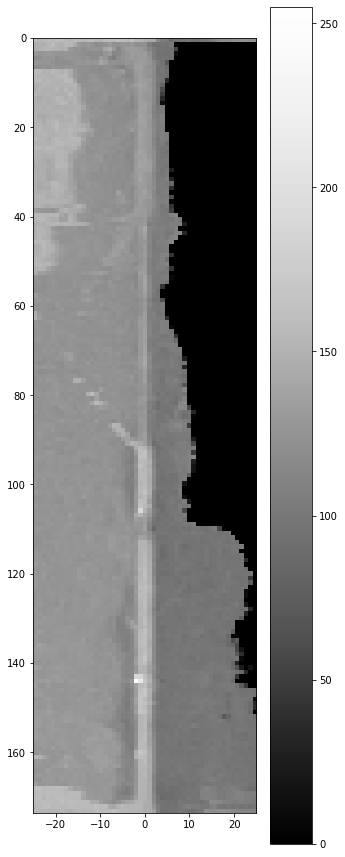

In [20]:
a.calculate_all()
a.render_image()
a.plot()